# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

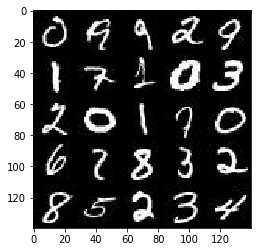

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

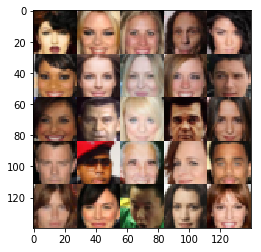

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Alpha for leaky relu
        alpha = 0.2
        
        # Convolution layer 1, no batch-normalization
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        # Convolution layer 2, with batch-normalization
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # Convolution layer 3, with batch-normalization
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Flatten and compute outputs
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        # Alpha for leaky relu
        alpha = 0.2

        # Full connected layer, 2x2x512
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        # Batch normalization
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # Transposed convolution layer 1, with batch-normalization
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # Transposed convolution layer 2, with batch-normalization
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [36]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                
                if steps == 1:
                    print('Initial output:')
                    show_generator_output(sess, n_images=16, input_z=input_z, out_channel_dim=image_channels, image_mode=data_image_mode)
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images=16, input_z=input_z, out_channel_dim=image_channels, image_mode=data_image_mode)                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Initial output:


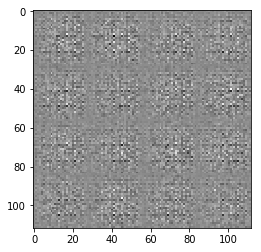

Epoch 1/2... Discriminator Loss: 0.3172... Generator Loss: 1.6759
Epoch 1/2... Discriminator Loss: 0.5831... Generator Loss: 0.8965
Epoch 1/2... Discriminator Loss: 2.1484... Generator Loss: 0.1425
Epoch 1/2... Discriminator Loss: 0.6715... Generator Loss: 8.4782
Epoch 1/2... Discriminator Loss: 0.4172... Generator Loss: 4.2974
Epoch 1/2... Discriminator Loss: 0.7147... Generator Loss: 0.7742
Epoch 1/2... Discriminator Loss: 0.5379... Generator Loss: 1.8808
Epoch 1/2... Discriminator Loss: 0.1965... Generator Loss: 3.1851
Epoch 1/2... Discriminator Loss: 0.5760... Generator Loss: 1.9252
Epoch 1/2... Discriminator Loss: 0.2990... Generator Loss: 2.3415


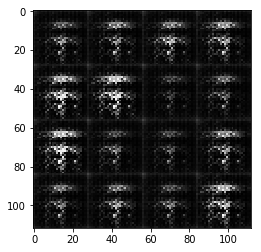

Epoch 1/2... Discriminator Loss: 0.1453... Generator Loss: 2.5331
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 0.9681
Epoch 1/2... Discriminator Loss: 0.2647... Generator Loss: 2.5443
Epoch 1/2... Discriminator Loss: 0.2449... Generator Loss: 2.5430
Epoch 1/2... Discriminator Loss: 0.1739... Generator Loss: 2.6764
Epoch 1/2... Discriminator Loss: 0.2504... Generator Loss: 2.5609
Epoch 1/2... Discriminator Loss: 0.0943... Generator Loss: 3.2624
Epoch 1/2... Discriminator Loss: 0.1456... Generator Loss: 2.9921
Epoch 1/2... Discriminator Loss: 0.1289... Generator Loss: 2.7439
Epoch 1/2... Discriminator Loss: 0.1468... Generator Loss: 3.3460


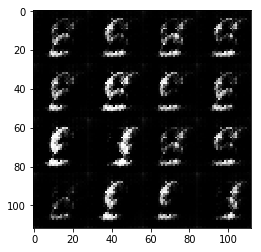

Epoch 1/2... Discriminator Loss: 0.2656... Generator Loss: 2.1896
Epoch 1/2... Discriminator Loss: 0.1315... Generator Loss: 3.9915
Epoch 1/2... Discriminator Loss: 0.0396... Generator Loss: 4.7180
Epoch 1/2... Discriminator Loss: 0.1220... Generator Loss: 2.8098
Epoch 1/2... Discriminator Loss: 0.3306... Generator Loss: 1.7141
Epoch 1/2... Discriminator Loss: 0.1563... Generator Loss: 2.6548
Epoch 1/2... Discriminator Loss: 0.1760... Generator Loss: 2.6420
Epoch 1/2... Discriminator Loss: 0.2592... Generator Loss: 2.3181
Epoch 1/2... Discriminator Loss: 0.1706... Generator Loss: 3.1771
Epoch 1/2... Discriminator Loss: 0.1584... Generator Loss: 3.2668


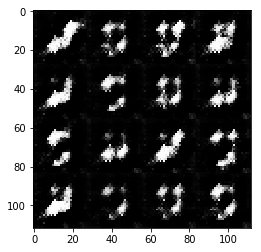

Epoch 1/2... Discriminator Loss: 0.4054... Generator Loss: 1.7074
Epoch 1/2... Discriminator Loss: 0.1796... Generator Loss: 2.7360
Epoch 1/2... Discriminator Loss: 0.2084... Generator Loss: 2.4612
Epoch 1/2... Discriminator Loss: 0.9943... Generator Loss: 7.0012
Epoch 1/2... Discriminator Loss: 0.4862... Generator Loss: 6.0212
Epoch 1/2... Discriminator Loss: 0.1870... Generator Loss: 3.5150
Epoch 1/2... Discriminator Loss: 0.4163... Generator Loss: 1.5836
Epoch 1/2... Discriminator Loss: 0.1473... Generator Loss: 3.2934
Epoch 1/2... Discriminator Loss: 0.8330... Generator Loss: 1.0392
Epoch 1/2... Discriminator Loss: 0.8397... Generator Loss: 4.6662


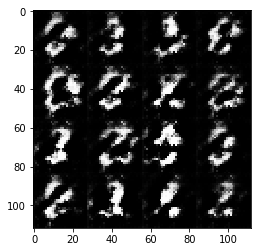

Epoch 1/2... Discriminator Loss: 0.3003... Generator Loss: 2.5473
Epoch 1/2... Discriminator Loss: 0.4258... Generator Loss: 2.9169
Epoch 1/2... Discriminator Loss: 0.3803... Generator Loss: 2.9048
Epoch 1/2... Discriminator Loss: 0.2966... Generator Loss: 1.9674
Epoch 1/2... Discriminator Loss: 0.2557... Generator Loss: 2.6298
Epoch 1/2... Discriminator Loss: 0.3258... Generator Loss: 2.2658
Epoch 1/2... Discriminator Loss: 0.3832... Generator Loss: 1.6650
Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.5944
Epoch 1/2... Discriminator Loss: 0.2741... Generator Loss: 3.4115
Epoch 1/2... Discriminator Loss: 0.3125... Generator Loss: 2.4769


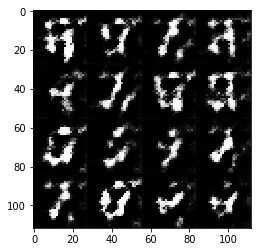

Epoch 1/2... Discriminator Loss: 0.4578... Generator Loss: 1.9503
Epoch 1/2... Discriminator Loss: 0.3483... Generator Loss: 1.8876
Epoch 1/2... Discriminator Loss: 0.5459... Generator Loss: 2.1000
Epoch 1/2... Discriminator Loss: 0.7244... Generator Loss: 1.2169
Epoch 1/2... Discriminator Loss: 0.5518... Generator Loss: 4.2220
Epoch 1/2... Discriminator Loss: 0.4403... Generator Loss: 1.7365
Epoch 1/2... Discriminator Loss: 0.3772... Generator Loss: 1.8423
Epoch 1/2... Discriminator Loss: 0.4222... Generator Loss: 1.5751
Epoch 1/2... Discriminator Loss: 0.3230... Generator Loss: 1.9084
Epoch 1/2... Discriminator Loss: 0.9446... Generator Loss: 0.8062


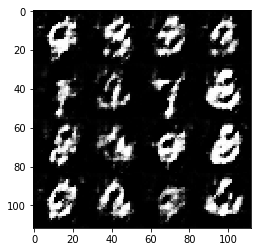

Epoch 1/2... Discriminator Loss: 0.3951... Generator Loss: 2.2690
Epoch 1/2... Discriminator Loss: 0.5649... Generator Loss: 1.4134
Epoch 1/2... Discriminator Loss: 0.4278... Generator Loss: 3.3079
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 1.8244
Epoch 1/2... Discriminator Loss: 0.4358... Generator Loss: 1.6900
Epoch 1/2... Discriminator Loss: 0.5946... Generator Loss: 1.4312
Epoch 1/2... Discriminator Loss: 0.5060... Generator Loss: 2.2834
Epoch 1/2... Discriminator Loss: 0.4969... Generator Loss: 1.5206
Epoch 1/2... Discriminator Loss: 0.3155... Generator Loss: 2.6196
Epoch 1/2... Discriminator Loss: 0.4597... Generator Loss: 1.7119


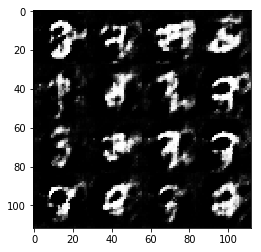

Epoch 1/2... Discriminator Loss: 0.5095... Generator Loss: 1.3287
Epoch 1/2... Discriminator Loss: 0.5715... Generator Loss: 1.6055
Epoch 1/2... Discriminator Loss: 0.6033... Generator Loss: 3.0396
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 1.6530
Epoch 1/2... Discriminator Loss: 0.4261... Generator Loss: 2.2580
Epoch 1/2... Discriminator Loss: 0.4907... Generator Loss: 2.5944
Epoch 1/2... Discriminator Loss: 0.5172... Generator Loss: 1.5658
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.6576
Epoch 1/2... Discriminator Loss: 0.5409... Generator Loss: 1.5939
Epoch 1/2... Discriminator Loss: 0.6006... Generator Loss: 1.5489


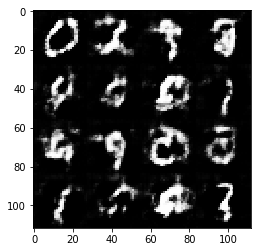

Epoch 1/2... Discriminator Loss: 0.4559... Generator Loss: 1.8794
Epoch 1/2... Discriminator Loss: 0.4165... Generator Loss: 2.0531
Epoch 1/2... Discriminator Loss: 1.0365... Generator Loss: 3.6623
Epoch 1/2... Discriminator Loss: 0.7316... Generator Loss: 1.0122
Epoch 1/2... Discriminator Loss: 0.6170... Generator Loss: 1.2614
Epoch 1/2... Discriminator Loss: 0.3701... Generator Loss: 2.1107
Epoch 1/2... Discriminator Loss: 0.5907... Generator Loss: 2.3166
Epoch 1/2... Discriminator Loss: 0.9272... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 2.1014... Generator Loss: 0.1822
Epoch 1/2... Discriminator Loss: 0.7897... Generator Loss: 0.9905


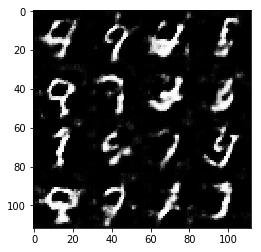

Epoch 1/2... Discriminator Loss: 0.5694... Generator Loss: 2.2438
Epoch 1/2... Discriminator Loss: 0.5021... Generator Loss: 1.8678
Epoch 1/2... Discriminator Loss: 0.8269... Generator Loss: 2.3475
Epoch 2/2... Discriminator Loss: 0.5555... Generator Loss: 1.4461
Epoch 2/2... Discriminator Loss: 0.6104... Generator Loss: 1.9538
Epoch 2/2... Discriminator Loss: 0.6517... Generator Loss: 1.2698
Epoch 2/2... Discriminator Loss: 0.5225... Generator Loss: 1.6271
Epoch 2/2... Discriminator Loss: 0.5964... Generator Loss: 2.2508
Epoch 2/2... Discriminator Loss: 0.6221... Generator Loss: 1.5831
Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 2.9192


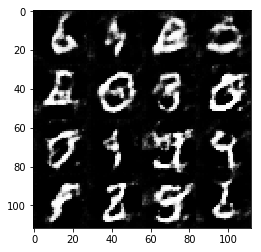

Epoch 2/2... Discriminator Loss: 0.4973... Generator Loss: 2.0491
Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 0.9721
Epoch 2/2... Discriminator Loss: 0.6316... Generator Loss: 1.2892
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 0.8181... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 0.6833... Generator Loss: 1.3615
Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 0.9980
Epoch 2/2... Discriminator Loss: 0.8680... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 0.6713... Generator Loss: 1.0862
Epoch 2/2... Discriminator Loss: 0.8663... Generator Loss: 0.8548


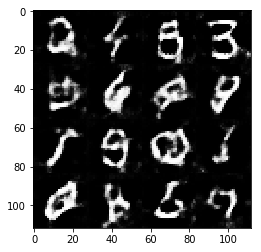

Epoch 2/2... Discriminator Loss: 0.5913... Generator Loss: 1.5336
Epoch 2/2... Discriminator Loss: 0.6924... Generator Loss: 1.5975
Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 0.8987
Epoch 2/2... Discriminator Loss: 0.6758... Generator Loss: 2.0520
Epoch 2/2... Discriminator Loss: 0.7508... Generator Loss: 1.0654
Epoch 2/2... Discriminator Loss: 0.6105... Generator Loss: 1.3598
Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 3.0579
Epoch 2/2... Discriminator Loss: 0.7076... Generator Loss: 1.3363
Epoch 2/2... Discriminator Loss: 0.6919... Generator Loss: 0.9173
Epoch 2/2... Discriminator Loss: 0.5733... Generator Loss: 1.7379


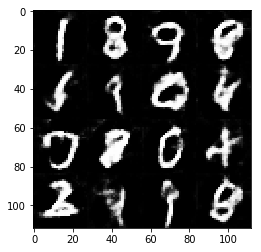

Epoch 2/2... Discriminator Loss: 0.6437... Generator Loss: 1.1915
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 0.7205
Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 0.5696
Epoch 2/2... Discriminator Loss: 0.7800... Generator Loss: 1.0572
Epoch 2/2... Discriminator Loss: 0.6838... Generator Loss: 1.1321
Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 1.5116
Epoch 2/2... Discriminator Loss: 0.9455... Generator Loss: 2.6382
Epoch 2/2... Discriminator Loss: 0.6363... Generator Loss: 1.6032
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 2.7411
Epoch 2/2... Discriminator Loss: 0.6658... Generator Loss: 1.6311


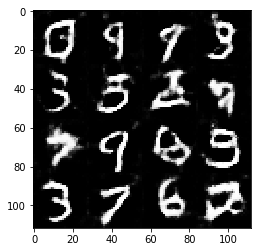

Epoch 2/2... Discriminator Loss: 0.6428... Generator Loss: 1.9544
Epoch 2/2... Discriminator Loss: 0.7721... Generator Loss: 1.6483
Epoch 2/2... Discriminator Loss: 0.8208... Generator Loss: 2.0241
Epoch 2/2... Discriminator Loss: 0.6709... Generator Loss: 1.3028
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 3.9642
Epoch 2/2... Discriminator Loss: 0.8621... Generator Loss: 0.7679
Epoch 2/2... Discriminator Loss: 0.7710... Generator Loss: 2.2221
Epoch 2/2... Discriminator Loss: 0.6351... Generator Loss: 1.2780
Epoch 2/2... Discriminator Loss: 0.6600... Generator Loss: 1.3229
Epoch 2/2... Discriminator Loss: 0.7090... Generator Loss: 0.9466


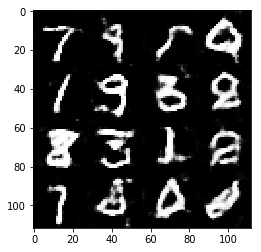

Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 1.9206
Epoch 2/2... Discriminator Loss: 0.7002... Generator Loss: 1.1360
Epoch 2/2... Discriminator Loss: 0.5650... Generator Loss: 1.5103
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 2.2844
Epoch 2/2... Discriminator Loss: 1.1054... Generator Loss: 0.5837
Epoch 2/2... Discriminator Loss: 0.7558... Generator Loss: 0.8491
Epoch 2/2... Discriminator Loss: 0.6784... Generator Loss: 1.0755
Epoch 2/2... Discriminator Loss: 0.7209... Generator Loss: 1.0254
Epoch 2/2... Discriminator Loss: 0.6288... Generator Loss: 1.1146
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 1.4704


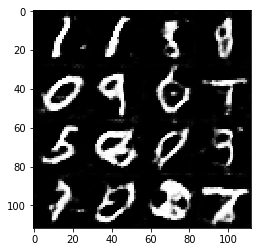

Epoch 2/2... Discriminator Loss: 0.7842... Generator Loss: 1.4978
Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 0.4218
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 1.1898
Epoch 2/2... Discriminator Loss: 0.5874... Generator Loss: 1.2137
Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 0.8986
Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 1.6429
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 1.2881
Epoch 2/2... Discriminator Loss: 0.6027... Generator Loss: 1.2458
Epoch 2/2... Discriminator Loss: 0.5977... Generator Loss: 1.3951
Epoch 2/2... Discriminator Loss: 0.7117... Generator Loss: 0.9187


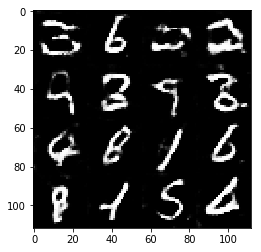

Epoch 2/2... Discriminator Loss: 0.7483... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 0.5803... Generator Loss: 2.5336
Epoch 2/2... Discriminator Loss: 0.7354... Generator Loss: 1.0347
Epoch 2/2... Discriminator Loss: 0.5320... Generator Loss: 1.8610
Epoch 2/2... Discriminator Loss: 0.6048... Generator Loss: 1.2112
Epoch 2/2... Discriminator Loss: 0.4881... Generator Loss: 1.6141
Epoch 2/2... Discriminator Loss: 0.5743... Generator Loss: 1.2230
Epoch 2/2... Discriminator Loss: 0.4819... Generator Loss: 1.5974
Epoch 2/2... Discriminator Loss: 0.5552... Generator Loss: 1.5115
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 4.5897


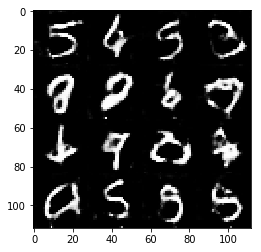

Epoch 2/2... Discriminator Loss: 0.7092... Generator Loss: 1.0216
Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 1.0739
Epoch 2/2... Discriminator Loss: 0.6721... Generator Loss: 1.0481
Epoch 2/2... Discriminator Loss: 0.7825... Generator Loss: 2.6635
Epoch 2/2... Discriminator Loss: 0.4800... Generator Loss: 1.4201
Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 2.4495
Epoch 2/2... Discriminator Loss: 0.5888... Generator Loss: 1.6434
Epoch 2/2... Discriminator Loss: 0.7998... Generator Loss: 1.2700
Epoch 2/2... Discriminator Loss: 0.6440... Generator Loss: 1.1544
Epoch 2/2... Discriminator Loss: 0.5939... Generator Loss: 1.1605


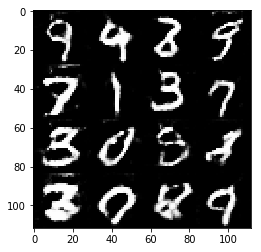

Epoch 2/2... Discriminator Loss: 0.7559... Generator Loss: 0.8476
Epoch 2/2... Discriminator Loss: 0.5590... Generator Loss: 1.2271
Epoch 2/2... Discriminator Loss: 0.7770... Generator Loss: 0.8895
Epoch 2/2... Discriminator Loss: 0.7628... Generator Loss: 0.7937
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 1.0530
Epoch 2/2... Discriminator Loss: 0.4322... Generator Loss: 1.7129
Epoch 2/2... Discriminator Loss: 0.6403... Generator Loss: 1.0329


In [38]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Initial output:


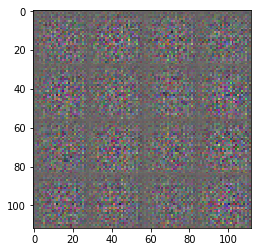

Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.5035
Epoch 1/1... Discriminator Loss: 0.3224... Generator Loss: 1.7621
Epoch 1/1... Discriminator Loss: 0.2631... Generator Loss: 1.9304
Epoch 1/1... Discriminator Loss: 0.0724... Generator Loss: 3.4862
Epoch 1/1... Discriminator Loss: 0.1434... Generator Loss: 2.6868
Epoch 1/1... Discriminator Loss: 0.1516... Generator Loss: 3.8631
Epoch 1/1... Discriminator Loss: 1.9964... Generator Loss: 13.4371
Epoch 1/1... Discriminator Loss: 0.1816... Generator Loss: 2.5069
Epoch 1/1... Discriminator Loss: 0.3258... Generator Loss: 9.5997
Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.3090


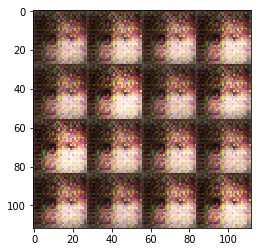

Epoch 1/1... Discriminator Loss: 0.3036... Generator Loss: 2.4899
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 1.7014
Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 1.7881
Epoch 1/1... Discriminator Loss: 0.2147... Generator Loss: 2.4212
Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 4.2356
Epoch 1/1... Discriminator Loss: 0.2970... Generator Loss: 2.0429
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 3.5107
Epoch 1/1... Discriminator Loss: 0.3225... Generator Loss: 2.2792
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 1.9566


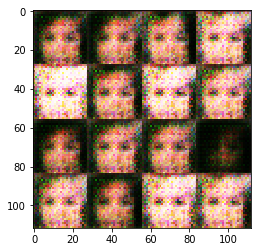

Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 4.0298
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 1.4045
Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 1.5780
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 4.5511
Epoch 1/1... Discriminator Loss: 0.2979... Generator Loss: 2.4317
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 2.1520
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.8756


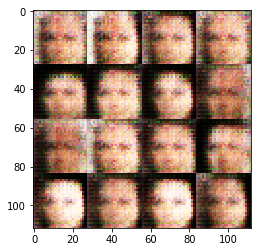

Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 2.1854
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 1.7469
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.1439
Epoch 1/1... Discriminator Loss: 0.8505... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 1.4797
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 1.7010


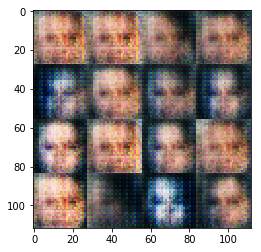

Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 0.7280... Generator Loss: 1.4847
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 1.3618
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 1.5402
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 3.3183
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 0.7435... Generator Loss: 1.2957
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.4668


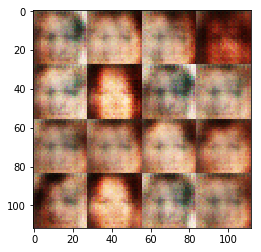

Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 0.5188... Generator Loss: 1.6115
Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 2.1863
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 1.5660
Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 1.6504
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 2.4312
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 1.3497
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 0.9438


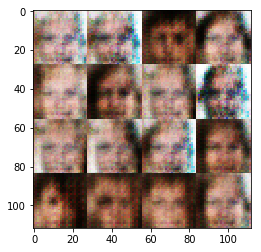

Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 2.2537
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.5702
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 1.6295
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.6120
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 1.5263
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.2502
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 2.0428


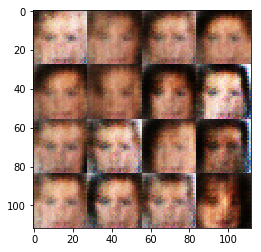

Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.2722
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.6870
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 0.6295... Generator Loss: 1.3369
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 1.6384
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.5139
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 1.3368
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.3913


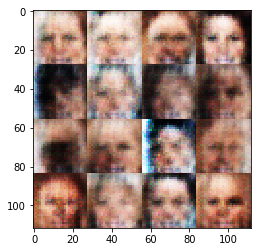

Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.5024
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.4771
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.4098
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 2.3552


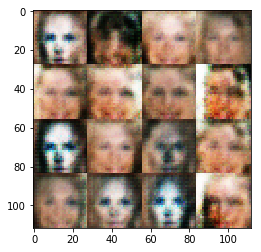

Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.6207
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 1.0506
Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.4364
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 1.6288


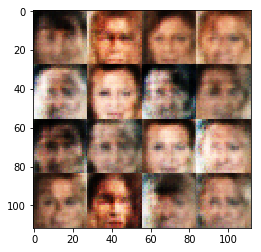

Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.4875
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.5161
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 2.0603
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 2.0763
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.5557


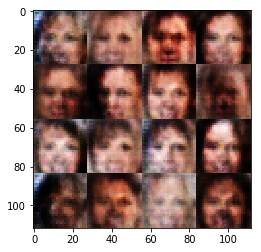

Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.3923
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.5152
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.0139
Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 1.3372
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 1.4219
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.7067
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 1.3816
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.2118


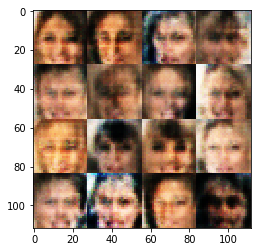

Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.3252
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.6145
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.6776
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.9980
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.6733


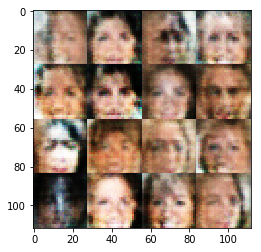

Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.8122
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 2.1979
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 1.5500


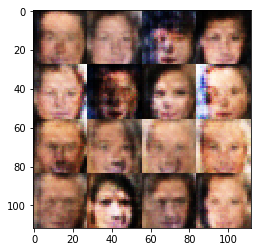

Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 1.7735
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.7605
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.4407
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.9160
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 1.5934


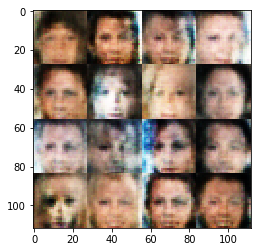

Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 1.7324
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.5597
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 1.3771
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.0911


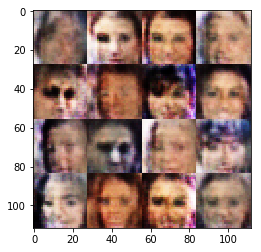

Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.7531
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 2.0952
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.0985


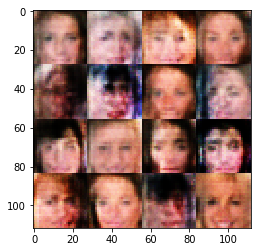

Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.1540
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.5266
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 1.3019
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.1443
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 2.0621
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.4201


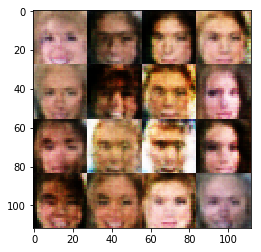

Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 1.9762
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.4684
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 1.7858
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 2.8621
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 0.9528


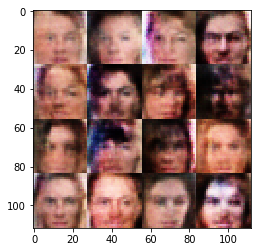

Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.2727
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.9084
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 0.9493


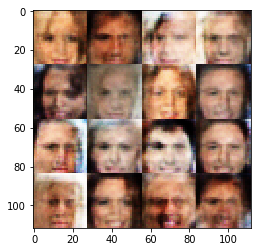

Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.9970
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.0305
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.6232


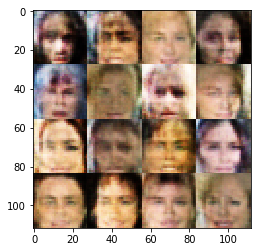

Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 2.2442


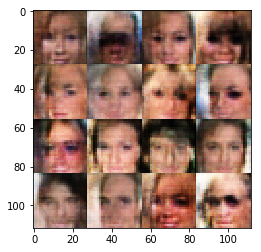

Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.9257


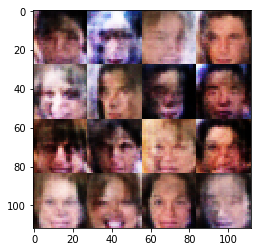

Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.1310
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.2833
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.3809
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.7352


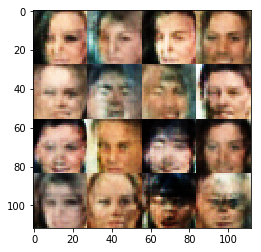

Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 1.8096
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 1.2183


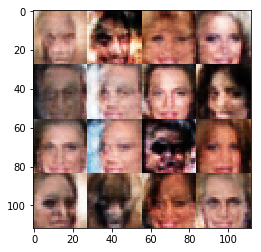

Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.4567
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 1.5614
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.4125
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.4967
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 0.7965


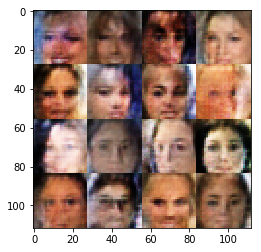

Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 1.5107
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.5986
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.4789
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 1.8443
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.5597


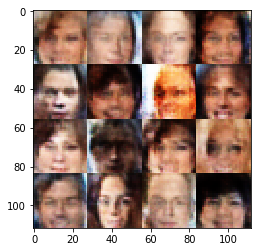

Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.5906
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.1870
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 1.3144
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.2313


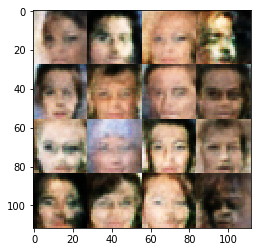

Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.4121
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.3589
Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 1.2921
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 1.3812
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 2.4665
Epoch 1/1... Discriminator Loss: 0.6518... Generator Loss: 1.9607
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 0.8435


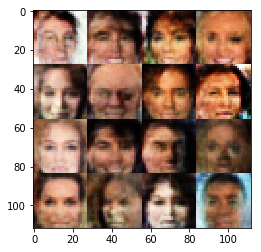

Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.7515
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 1.8728
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 1.3287


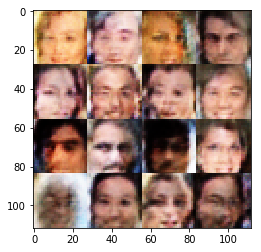

Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.8832
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.5874
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.8737
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 1.5087
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 1.7043
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.3588


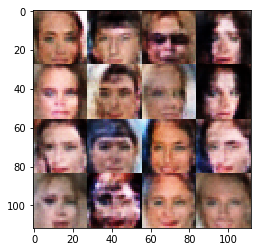

Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.8785
Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.1269


In [39]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。